### Importing Packages

In [2]:
# pip install sktime[all_extras] --user

In [1]:
#!pip install optbinning

In [2]:
#pip install tensorflow --user

In [1]:
# Importing Numpy, Pandas, Seaborn and Tensorfow packages
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from numpy import array
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.preprocessing.sequence import TimeseriesGenerator
from tensorflow.keras.layers import Dropout
import warnings
warnings.filterwarnings("ignore")
import tensorflow as tf
from tensorflow import keras
from pandas.tseries.offsets import DateOffset

In [2]:
# Importing Sklearn & Sktime packages
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import Perceptron
from sklearn.linear_model import PassiveAggressiveClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.dummy import DummyClassifier
from sklearn.linear_model import SGDClassifier
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.metrics import mean_absolute_error
from sklearn import preprocessing 
from sklearn.linear_model import RidgeClassifier
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import balanced_accuracy_score

from sktime.forecasting.theta import ThetaForecaster
from sktime.utils import plotting
from sktime.utils.plotting import plot_series
from sktime.forecasting.base import ForecastingHorizon
from sktime.forecasting.naive import NaiveForecaster
from sktime.forecasting.model_selection import temporal_train_test_split
from sktime.performance_metrics.forecasting import mean_absolute_percentage_error
from sktime.transformations.panel.compose import ColumnConcatenator
from sktime.classification.compose import ColumnEnsembleClassifier
from sktime.classification.dictionary_based import BOSSEnsemble
from sktime.classification.interval_based import TimeSeriesForestClassifier
from sktime.datatypes._panel._convert import from_3d_numpy_to_nested
from sktime.transformations.panel.rocket import Rocket
from sktime.utils.plotting import plot_series

In [5]:
# Importing further packages
from google.cloud import bigquery
import datetime
from datetime import timedelta
from optbinning import ContinuousOptimalBinning

In [3]:
# Setting client for SQL big query
client = bigquery.Client(location="US",project='umg-data-science')
print("Bigquery client using project: {}".format(client.project))

# <b>Methodology & Methods<b>

## <b>Data Understanding<b>

## <u>Sampling<u>

#### Removing playlists that do not have at least one save per week of the year

In [ ]:
# importing the concatenated save metric table (all 12 months)
df = pd.read_csv('yr_union.csv')
# converting stream date to datetime format
df['stream_datetime'] = pd.to_datetime(df['stream_datetime'])

# creating new feature 'first_day' which is the first (monday) of the week
df['first_day'] = df['stream_datetime'] - df['stream_datetime'].dt.weekday * np.timedelta64(1, 'D')
# droppping final week as crossover with first week of the year
df.drop(df[df.first_day == '2021-04-26'].index, inplace=True)

# calculating the number of weeks where a playlist has at least one save
df_size = pd.DataFrame(df.groupby(['source_uri', 'first_day']).size(), columns = ['size'])
df_size_wk = pd.DataFrame(df_size.groupby(level=0).size(), columns = ['num_week_where_saves'])
df_all_weeks = df_size_wk.loc[df_size_wk['num_week_where_saves']==52]

# merging back with the original dataframe, only including playlists that have a save every week of the year
df_all_weeks.reset_index(inplace = True)
df_53 = pd.merge(df_all_weeks, df, on='source_uri')
df_53 = pd.merge(df_53, df_size, on='source_uri')

# aggregating the number of saves for each week, for each playlist
df_save_pw = pd.DataFrame(df_53.groupby(['source_uri', 'first_day'])['size'].sum())
df_save_pw.rename(columns={'size':'saves_wk'}, inplace=True)
df_save_pw.reset_index(inplace = True)

# merging back into main dataframe
df = pd.merge(df_53, df_save_pw,  how='left', left_on=['source_uri','first_day'], right_on = ['source_uri','first_day'])
df.drop(['size'], inplace = True, axis = 1)
# dropping duplicates as multiple rows for the same playlist_id and same first_day, with the same values of aggregated saves
df.drop_duplicates(subset=['source_uri', 'first_day'], inplace = True)
df = df.set_index(['source_uri', 'first_day'])
df.sort_values(by=['source_uri', 'first_day'], inplace = True)
df.drop(['num_week_where_saves', 'Unnamed: 0'], inplace = True, axis = 1)

# saving to csv
df.to_csv('yr_52.csv')

#### Removing playlists that are not both in the filtered/target table, and the 'save-every-week' 52 table

In [122]:
# Importing 'save-every-week' 52 table
df = pd.read_csv('yr_52.csv')
df.drop(columns = 'stream_datetime', axis = 1, inplace = True)
df.drop(columns = 'anonymized_user_id', axis = 1, inplace = True)
df.drop(columns = 'isrc', axis = 1, inplace = True)
df.drop(columns = 'partner_track_uri', axis = 1, inplace = True)

In [121]:
# Loading filtered/target table
query_fil = """
    SELECT * 
    FROM `umg-data-science.maxwell_ds_v2.new_filtered_playlists`
"""

query_job_fil = client.query(
    query_fil, # Location which matches the dataset referenced in the query
    location="US")  # API request

df_filtered = query_job_fil.to_dataframe()
df_filtered.head()

,playlist_id,report_date,playlist_uri,playlist_name,playlist_description,playlist_owner,playlist_owner_uri,image_url,num_followers,num_playlists_owner,...,different_su_country_pct,account_premium_pct,account_free_pct,type_short_pct,type_completed_pct,device_other_pct,device_pc_pct,device_mobile_pct,followers,name
0,37i9dQZF1DX66m4icL86Ru,2021-05-08,spotify:playlist:37i9dQZF1DX66m4icL86Ru,BBE,"Bad b**** energy. Be blessed, be spicy. Cover:...",spotify,spotify:user:spotify,https://i.scdn.co/image/ab67706f000000036c0993...,83139,37115,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,None
1,37i9dQZF1DX66m4icL86Ru,2021-05-10,spotify:playlist:37i9dQZF1DX66m4icL86Ru,BBE,"Bad b**** energy. Be blessed, be spicy. Cover:...",spotify,spotify:user:spotify,https://i.scdn.co/image/ab67706f000000036c0993...,86769,37135,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,None
2,37i9dQZF1DX0sDai2F5jCQ,2022-01-09,spotify:playlist:37i9dQZF1DX0sDai2F5jCQ,A1,The home of Hip-Hop culture. Cover: 2 Chainz,spotify,spotify:user:spotify,https://i.scdn.co/image/ab67706f000000039b4ecf...,377772,40161,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,None
3,37i9dQZF1DX0sDai2F5jCQ,2021-09-12,spotify:playlist:37i9dQZF1DX0sDai2F5jCQ,A1,The home of Hip-Hop culture. Cover: Drake,spotify,spotify:user:spotify,https://i.scdn.co/image/ab67706f00000003a891db...,367586,38470,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,None
4,37i9dQZF1DX0sDai2F5jCQ,2021-11-06,spotify:playlist:37i9dQZF1DX0sDai2F5jCQ,A1,The home of Hip-Hop culture. Cover: Travis Scott,spotify,spotify:user:spotify,https://i.scdn.co/image/ab67706f000000037d0dc1...,372079,39277,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,None


In [1]:
# Function to determine intersection of remove list and all list
def intersection(lst1, lst2):
    lst3 = [value for value in lst1 if value in lst2]
    return lst3

In [131]:
# Datetime formatting
df_filtered.rename(columns={'playlist_uri': 'source_uri'}, inplace=True)
df_filtered['report_date'] = pd.to_datetime(df_filtered['report_date'])
df_filtered['first_day'] = df_filtered['report_date'] - df_filtered['report_date'].dt.weekday * np.timedelta64(1, 'D')
df_filtered.drop(df_filtered[df_filtered.first_day == '2021-04-26'].index, inplace=True)
df_filtered.drop_duplicates(subset=['source_uri', 'first_day'], inplace = True)
df_filtered.drop(columns = 'report_date', axis = 1, inplace = True)
df_filtered.drop(['streams', 'users', 'streams_per_user',
       'different_su_country_pct', 'account_premium_pct', 'account_free_pct',
       'type_short_pct', 'type_completed_pct', 'device_other_pct',
       'device_pc_pct', 'device_mobile_pct', 'followers', 'name'], axis = 1, inplace = True)
df_filtered['first_day'] = pd.to_datetime(df_filtered['first_day'])
df_filtered['first_day'] = pd.to_datetime(df_filtered['first_day']).dt.date

# Creating test lists 
filt_list = df_filtered['source_uri'].tolist()
df_list = df['source_uri'].tolist()
int_list = intersection(filt_list, df_list)
df_test = df[df['source_uri'].isin(int_list)]
df_test['first_day'] = pd.to_datetime(df_test['first_day'])
fs_df = df_filtered.merge(df_test, on=['first_day', 'source_uri'])
fs_df.set_index(['source_uri', 'first_day'], inplace = True)

# Cutting two weeks from dataframe due to large amount of null values
df_size = pd.DataFrame(fs_df.groupby(level=0).size(), columns = ['num_week_where_saves'])
df_all_weeks = df_size.loc[df_size['num_week_where_saves']==50]
# Creating a list of source_uri(s) which can be removed from dataframe
remove_list = df_all_weeks.index.to_list()
df_rem = fs_df.reset_index()
# Creating a list off all source_uri(s)
all_list = df_rem['source_uri'].to_list()

In [151]:
# Applying the function
int_list_2 = intersection(remove_list, all_list)
len(int_list_2)

In [154]:
# Keeping the values that do not include the remove list
fs_df.reset_index(inplace = True)
df_50 = fs_df[fs_df['source_uri'].isin(int_list_2)]
df_50.set_index(['source_uri', 'first_day'], inplace = True)
df_50.sort_values(['source_uri','first_day'], inplace = True)

In [158]:
# Checking the playlists have a save every 50 weeks
df_check = pd.DataFrame(df_50.groupby(level=0).size(), columns = ['num_week_where_saves'])
df_check_2 = df_check.loc[df_check['num_week_where_saves']==50]
df_check_2.head()

,num_week_where_saves
source_uri,
spotify:playlist:37i9dQZF1DWSBi5svWQ9Nk,50
spotify:playlist:37i9dQZF1DWSJHnPb1f0X3,50
spotify:playlist:37i9dQZF1DWSP55jZj2ES3,50
spotify:playlist:37i9dQZF1DWSPMbB1kcXmo,50
spotify:playlist:37i9dQZF1DWSTqUqJcxFk6,50


In [159]:
df_check_2.reset_index(inplace = True)

## <u>Exploratory Data Analysis (EDA)<u>

In [ ]:
# Conducted on Business Intelligence platforms - Tableau and Google's Data Studio

## <b>Pre-Processing<b>

## <u>Target Variable<u>

In [6]:
# Target Variable (Conversion) was originally created in SQL - here the categorisation was conducted. 

In [2]:
df = pd.read_csv('df_done.csv')
df_y = df.copy()
df_y.sort_values(by = 'saves_wk', ascending = False, inplace = True)

/opt/conda/lib/python3.7/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


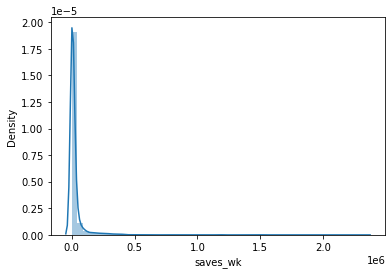

In [6]:
# Exploring the distribution of the dependent variable
ax = sns.distplot(df_y['saves_wk'])

In [7]:
# Defining variables, univariate so weeks for both
variable = "saves_wk"
x = df['saves_wk'].values
y = df['saves_wk'].values

In [ ]:
# Defining and fitting the bins
optb = ContinuousOptimalBinning(name=variable, dtype="numerical", outlier_detector = 'zscore', prebinning_method = 'uniform', max_n_prebins = 11)
optb.fit(x, y)

In [46]:
binning_table = optb.binning_table
binning_table.build()

,Bin,Count,Count (%),Sum,Std,Mean,Min,Max,Zeros count,WoE,IV
0,"(-inf, 2842.27)",4246,0.338596,6671357.0,716.488429,1571.209845,169.0,2840.0,0,-5538.910650,1875.455711
1,"[2842.27, 5515.55)",2818,0.224721,11324519.0,756.290879,4018.636977,2844.0,5512.0,0,-3091.483518,694.720937
2,"[5515.55, 8188.82)",1668,0.133014,11220126.0,761.116275,6726.694245,5520.0,8184.0,0,-383.426250,51.001195
3,"[8188.82, 10862.09)",1010,0.080542,9574696.0,766.677709,9479.897030,8190.0,10850.0,0,2369.776535,190.867169
4,"[10862.09, 13535.36)",734,0.058533,8910310.0,762.766475,12139.386921,10864.0,13532.0,0,5029.266427,294.376520
5,"[13535.36, 16208.64)",540,0.043062,8009581.0,761.812749,14832.557407,13546.0,16207.0,0,7722.436913,332.545130
6,"[16208.64, 18881.91)",429,0.034211,7457653.0,770.773285,17383.806527,16224.0,18860.0,0,10273.686032,351.468206
7,"[18881.91, 21555.18)",334,0.026635,6747176.0,747.252614,20201.125749,18900.0,21551.0,0,13091.005254,348.675898
8,"[21555.18, 24228.45)",298,0.023764,6814292.0,801.657163,22866.751678,21560.0,24220.0,0,15756.631183,374.439880
9,"[24228.45, 26901.73)",242,0.019298,6181182.0,754.127761,25542.074380,24250.0,26884.0,0,18431.953886,355.704373


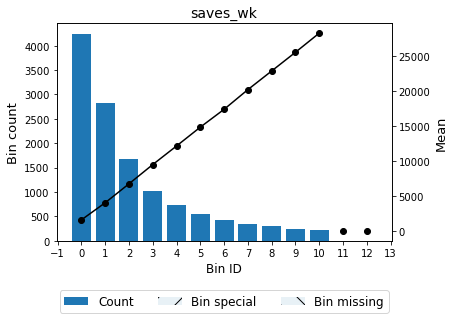

In [47]:
binning_table.plot()

In [48]:
binning_table.analysis()

-------------------------------------------------
OptimalBinning: Continuous Binning Table Analysis
-------------------------------------------------

  General metrics

    IV                    5242.35568696
    WoE                 117079.32610170
    WoE (normalized)        16.46657412
    HHI                      0.19773488
    HHI (normalized)         0.13087945
    Quality score            0.81633965

  Monotonic trend             ascending

  Significance tests

    Bin A  Bin B  t-statistic       p-value
        0      1  -135.994275  0.000000e+00
        1      2  -115.443278  0.000000e+00
        2      3   -90.316242  0.000000e+00
        3      4   -71.730622  0.000000e+00
        4      5   -62.322567  0.000000e+00
        5      6   -51.442676 4.998614e-272
        6      7   -50.958144 6.097532e-242
        7      8   -43.081623 4.238551e-187
        8      9   -39.852170 4.367778e-161
        9     10   -38.488499 3.774027e-145



In [49]:
optb.splits

array([ 2842.27272727,  5515.54545455,  8188.81818182, 10862.09090909,
       13535.36363636, 16208.63636364, 18881.90909091, 21555.18181818,
       24228.45454545, 26901.72727273])

In [50]:
# Creating function to apply the categories
def conditions(s):
    if (s['saves_wk'] <= 2842.27272727):
        return 1
    elif (s['saves_wk'] > 2842.27272727) and (s['saves_wk'] <= 5515.54545455):
        return 2
    elif (s['saves_wk'] > 5515.54545455) and (s['saves_wk'] <= 8188.81818182):
        return 3
    elif (s['saves_wk'] > 8188.81818182) and (s['saves_wk'] <= 10862.09090909):
        return 4
    elif (s['saves_wk'] > 10862.09090909) and (s['saves_wk'] <= 13535.36363636):
        return 5
    elif (s['saves_wk'] > 13535.36363636) and (s['saves_wk'] <= 16208.63636364):
        return 6
    elif (s['saves_wk'] > 16208.63636364) and (s['saves_wk'] <= 18881.90909091):
        return 7
    elif (s['saves_wk'] > 18881.90909091) and (s['saves_wk'] <= 21555.18181818):
        return 8
    elif (s['saves_wk'] > 21555.18181818) and (s['saves_wk'] <= 24228.45454545):
        return 9
    elif (s['saves_wk'] > 24228.45454545) and (s['saves_wk'] <= 26901.72727273):
        return 10
    else:
        return 11

In [5]:
# Applying the function
df['saves_cat'] = df.apply(conditions, axis=1)

## <u>Feature Extraction & Engineering<u>

#### Aggregating and merging estimated streams table

In [163]:
# Loading the pre-merged dataset using bigquery client function directly from sql workspace
query_exp = """
    SELECT * 
    FROM `umg-data-science.maxwell_ds_v2.new_aggregated_est_streams`
"""

query_job_exp = client.query(
    query_exp, # Location which matches the dataset referenced in the query
    location="US")  # API request

df_exp = query_job_exp.to_dataframe()
df_exp.head()

,playlist_uri,week_start,streams_actual,streams_extimate,streams_disparity_act_est
0,spotify:playlist:37i9dQZF1DX1eh709zIoRH,2021-05-03,355086.0,2950233.0,-573520.0
1,spotify:playlist:37i9dQZF1DXcBWIGoYBM5M,2021-05-03,144685960.0,420366438.0,-41420556.0
2,spotify:playlist:37i9dQZF1DWY4lFlS4Pnso,2021-05-03,13067250.0,38058020.0,-3038332.0
3,spotify:playlist:37i9dQZF1DX9jVKQ9Qb4yD,2021-05-03,1099618.0,2723548.0,-246375.0
4,spotify:playlist:37i9dQZF1DX4o1oenSJRJd,2021-05-03,21821181.0,102543597.0,-27914696.0


In [165]:
df_exp.rename(columns = {'playlist_uri':'source_uri', 'week_start':'first_day'}, inplace=True)

In [166]:
df_exp['first_day'] = pd.to_datetime(df_exp['first_day'])

In [167]:
df_50.reset_index(inplace = True)

In [168]:
df = df_50.merge(df_exp, on=['source_uri', 'first_day'])

#### Merging Audio features (already aggregated)

In [170]:
# Loading the pre-merged dataset using bigquery client function directly from sql workspace
query_aud = """
    SELECT *
    FROM `umg-data-science.maxwell_ds_v2.big_audio_agg_week`
"""

query_job_aud = client.query(
    query_aud, # Location which matches the dataset referenced in the query
    location="US")  # API request

df_aud = query_job_aud.to_dataframe()
df_aud.head()

,playlist_id,first_day,track_position_avg,peak_position_avg,listeners_avg,daily_streams_avg,daily_users_avg,repeat_users_avg,yesterday_track_position_avg,seven_days_ago_track_position_avg,duration_ms_avg,acousticness_avg,danceability_avg,energy_avg,instrumentalness_avg,liveness_avg,loudness_avg,speechiness_avg,valence_avg,tempo_avg
0,37i9dQZF1DWSBi5svWQ9Nk,2021-05-03,15.258646,10.365389,312617.110452,NaN,NaN,NaN,15.565947,14.426053,173101.583053,0.091297,0.761718,0.653851,4.139396e-07,0.052794,-5.682087,0.035204,0.634612,105.444474
1,37i9dQZF1DWSBi5svWQ9Nk,2021-05-10,36.847678,34.239332,308395.133198,11743.754624,9402.306966,1482.082251,35.994512,34.579697,212934.541560,0.128595,0.583487,0.772844,1.668494e-05,0.217512,-5.440822,0.046640,0.398616,149.989613
2,37i9dQZF1DWSBi5svWQ9Nk,2021-05-17,17.829953,7.999652,298351.567552,17228.608246,13683.513196,2302.715296,17.231874,16.024333,192986.389781,0.194308,0.650699,0.706171,9.075702e-03,0.121707,-5.127627,0.126448,0.655322,142.473101
3,37i9dQZF1DWSBi5svWQ9Nk,2021-05-24,34.462119,30.774381,312013.975451,1637.040940,1311.361881,206.599799,32.796523,14.479408,168632.255504,0.110510,0.694066,0.532265,1.193603e-03,0.173246,-7.051036,0.089575,0.624177,105.448945
4,37i9dQZF1DWSBi5svWQ9Nk,2021-05-31,27.784691,20.056387,293853.446017,10513.904316,8867.257881,1162.150360,27.856602,26.562812,170478.536573,0.168886,0.690258,0.731124,1.501342e-03,0.131557,-5.790447,0.055003,0.648086,121.838195


In [173]:
df_aud['first_day'] = pd.to_datetime(df_aud['first_day'])
df = pd.merge(df, df_aud,  how='left', left_on=['playlist_id', 'first_day'], right_on = ['playlist_id', 'first_day'])
df

,source_uri,first_day,playlist_id,playlist_name,playlist_description,playlist_owner,playlist_owner_uri,image_url,num_followers,num_playlists_owner,...,duration_ms_avg,acousticness_avg,danceability_avg,energy_avg,instrumentalness_avg,liveness_avg,loudness_avg,speechiness_avg,valence_avg,tempo_avg
0,spotify:playlist:37i9dQZF1DWSBi5svWQ9Nk,2021-05-03,37i9dQZF1DWSBi5svWQ9Nk,Hot Hits NL,De 50 populairste hits van Nederland. Cover: ...,spotify,spotify:user:spotify,https://i.scdn.co/image/ab67706f0000000382bbec...,782770,37066,...,173101.583053,0.091297,0.761718,0.653851,4.139396e-07,0.052794,-5.682087,0.035204,0.634612,105.444474
1,spotify:playlist:37i9dQZF1DWSBi5svWQ9Nk,2021-05-10,37i9dQZF1DWSBi5svWQ9Nk,Hot Hits NL,De 50 populairste hits van Nederland. Cover: ...,spotify,spotify:user:spotify,https://i.scdn.co/image/ab67706f000000034332ad...,783918,37160,...,212934.541560,0.128595,0.583487,0.772844,1.668494e-05,0.217512,-5.440822,0.046640,0.398616,149.989613
2,spotify:playlist:37i9dQZF1DWSBi5svWQ9Nk,2021-05-17,37i9dQZF1DWSBi5svWQ9Nk,Hot Hits NL,De 50 populairste hits van Nederland. Cover: ...,spotify,spotify:user:spotify,https://i.scdn.co/image/ab67706f00000003bf7574...,784117,37185,...,192986.389781,0.194308,0.650699,0.706171,9.075702e-03,0.121707,-5.127627,0.126448,0.655322,142.473101
3,spotify:playlist:37i9dQZF1DWSBi5svWQ9Nk,2021-05-24,37i9dQZF1DWSBi5svWQ9Nk,Hot Hits NL,De 50 populairste hits van Nederland. Cover: ...,spotify,spotify:user:spotify,https://i.scdn.co/image/ab67706f000000036d3305...,785020,37269,...,168632.255504,0.110510,0.694066,0.532265,1.193603e-03,0.173246,-7.051036,0.089575,0.624177,105.448945
4,spotify:playlist:37i9dQZF1DWSBi5svWQ9Nk,2021-05-31,37i9dQZF1DWSBi5svWQ9Nk,Hot Hits NL,De 50 populairste hits van Nederland. Cover: O...,spotify,spotify:user:spotify,https://i.scdn.co/image/ab67706f00000003aa8305...,786398,37354,...,170478.536573,0.168886,0.690258,0.731124,1.501342e-03,0.131557,-5.790447,0.055003,0.648086,121.838195
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
15045,spotify:playlist:37i9dQZF1DXe891Ptl9O2H,2022-03-14,37i9dQZF1DXe891Ptl9O2H,La Crème,Le meilleur du meilleur de la scène indie fran...,spotify,spotify:user:spotify,https://i.scdn.co/image/ab67706f000000034b9771...,37839,39258,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
15046,spotify:playlist:37i9dQZF1DXe891Ptl9O2H,2022-03-21,37i9dQZF1DXe891Ptl9O2H,La Crème,Le meilleur du meilleur de la scène indie fran...,spotify,spotify:user:spotify,https://i.scdn.co/image/ab67706f000000034b9771...,38131,39330,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
15047,spotify:playlist:37i9dQZF1DXe891Ptl9O2H,2022-03-28,37i9dQZF1DXe891Ptl9O2H,La Crème,Le meilleur du meilleur de la scène indie fran...,spotify,spotify:user:spotify,https://i.scdn.co/image/ab67706f000000034b9771...,38176,39348,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
15048,spotify:playlist:37i9dQZF1DXe891Ptl9O2H,2022-04-04,37i9dQZF1DXe891Ptl9O2H,La Crème,Le meilleur du meilleur de la scène indie fran...,spotify,spotify:user:spotify,https://i.scdn.co/image/ab67706f000000034b9771...,38361,39345,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


#### Aggregating (finding mode) and merging top genre feature

In [176]:
# Loading the pre-merged dataset using bigquery client function directly from sql workspace
query_gen = """
    SELECT *
    FROM `umg-data-science.maxwell_ds_v2.new_genre_top_count`
"""

query_job_gen = client.query(
    query_gen, # Location which matches the dataset referenced in the query
    location="US")  # API request

df_gen = query_job_gen.to_dataframe()
df_gen.head()

,playlist_id,r2_genre,r2_genre_count
0,37i9dQZF1DWSqmBTGDYngZ,Pop,141700003
1,37i9dQZF1DX5Ejj0EkURtP,Pop,107079691
2,37i9dQZF1DWWMOmoXKqHTD,Pop,96885247
3,37i9dQZF1DWZKuerrwoAGz,Pop,81168287
4,37i9dQZF1DXaMu9xyX1HzK,Pop,72613281


In [182]:
df_gen = df_gen.set_index(['playlist_id']).sort_values(['r2_genre_count'], ascending = False)
df_gen = df_gen[~df_gen.index.duplicated(keep='first')]
df_gen.reset_index(inplace = True)
df_gen.drop(['r2_genre_count'], axis = 1, inplace = True)
df_gen.rename(columns = {'r2_genre':'top_genre'}, inplace = True)
df_gen

,playlist_id,top_genre
0,37i9dQZF1DWSqmBTGDYngZ,Pop
1,37i9dQZF1DX5Ejj0EkURtP,Pop
2,37i9dQZF1DWWMOmoXKqHTD,Pop
3,37i9dQZF1DWZKuerrwoAGz,Pop
4,37i9dQZF1DXaMu9xyX1HzK,Pop
...,...,...
296,37i9dQZF1DXd8cOUiye1o2,Pop
297,37i9dQZF1DWTcqUzwhNmKv,Rock
298,37i9dQZF1DWY9crkqLGj4o,Classic
299,37i9dQZF1DXcedEPj5nsZ0,Pop


#### Aggregating (finding mode) and merging top label feature

In [184]:
# Loading the pre-merged dataset using bigquery client function directly from sql workspace
query_lab = """
    SELECT *
    FROM `umg-data-science.maxwell_ds_v2.new_label_count`
"""

query_job_lab = client.query(
    query_lab, # Location which matches the dataset referenced in the query
    location="US")  # API request

df_lab = query_job_lab.to_dataframe()
df_lab.head()

,playlist_id,label_name,label_name_count
0,37i9dQZF1DWSqmBTGDYngZ,,70136968
1,37i9dQZF1DWTmvXBN4DgpA,,59160317
2,37i9dQZF1DX5Ejj0EkURtP,,54135384
3,37i9dQZF1DWWMOmoXKqHTD,,52699794
4,37i9dQZF1DWZKuerrwoAGz,,45298054


In [192]:
df_lab = df_lab.replace(r'^s*$', float('NaN'), regex = True)
df_lab.dropna(inplace = True)      
df_lab = df_lab.set_index(['playlist_id']).sort_values(['label_name_count'], ascending = False)
df_lab = df_lab[~df_lab.index.duplicated(keep='first')]
df_lab.reset_index(inplace = True)
df_lab.drop(['label_name_count'], axis = 1, inplace = True)
df_lab.rename(columns = {'label_name':'top_label'}, inplace = True)
df_lab

,playlist_id,top_label
0,37i9dQZF1DWSqmBTGDYngZ,IGA
1,37i9dQZF1DWTmvXBN4DgpA,IGA
2,37i9dQZF1DWWMOmoXKqHTD,IGA
3,37i9dQZF1DX5Ejj0EkURtP,IGA
4,37i9dQZF1DWZVAVMhIe3pV,IGA
...,...,...
282,37i9dQZF1DX1ct2TQrAvRf,EMI
283,37i9dQZF1DWTTCCEjVC99N,Distributed Labels
284,37i9dQZF1DWZxM58TRkuqg,IGA
285,37i9dQZF1DWVLcZxJO5zyf,Virgin Music Intl


#### Aggregating (finding mode) and merging top language feature

In [194]:
# Loading the pre-merged dataset using bigquery client function directly from sql workspace
query_lan = """
    SELECT *
    FROM `umg-data-science.maxwell_ds_v2.new_language_count`
"""

query_job_lan = client.query(
    query_lan, # Location which matches the dataset referenced in the query
    location="US")  # API request

df_lan = query_job_lan.to_dataframe()
df_lan.head()

,playlist_id,audio_language,audio_language_count
0,37i9dQZF1DWSqmBTGDYngZ,English,174068121
1,37i9dQZF1DX5Ejj0EkURtP,English,133576950
2,37i9dQZF1DWTmvXBN4DgpA,English,124646073
3,37i9dQZF1DWWMOmoXKqHTD,English,122939918
4,37i9dQZF1DWZKuerrwoAGz,English,97615557


In [202]:
df_lan = df_lan.replace(r'^s*$', float('NaN'), regex = True)
df_lan.dropna(inplace = True)   
df_lan = df_lan.set_index(['playlist_id']).sort_values(['audio_language_count'], ascending = False)
df_lan = df_lan[~df_lan.index.duplicated(keep='first')]
df_lan.reset_index(inplace = True)
df_lan.drop(['audio_language_count'], axis = 1, inplace = True)
df_lan.rename(columns = {'audio_language':'top_language'}, inplace = True)
df_lan

,playlist_id,top_language
0,37i9dQZF1DWSqmBTGDYngZ,English
1,37i9dQZF1DX5Ejj0EkURtP,English
2,37i9dQZF1DWTmvXBN4DgpA,English
3,37i9dQZF1DWWMOmoXKqHTD,English
4,37i9dQZF1DWZKuerrwoAGz,English
...,...,...
296,37i9dQZF1DXd8cOUiye1o2,Hindi
297,37i9dQZF1DWTcqUzwhNmKv,English
298,37i9dQZF1DXcedEPj5nsZ0,Portuguese
299,37i9dQZF1DWY9crkqLGj4o,Portuguese


#### Merge all three with main dataframe

In [204]:
df = pd.merge(df, df_gen,  how='left', left_on=['playlist_id'], right_on = ['playlist_id'])

In [205]:
df = pd.merge(df, df_lab,  how='left', left_on=['playlist_id'], right_on = ['playlist_id'])

In [206]:
df = pd.merge(df, df_lan,  how='left', left_on=['playlist_id'], right_on = ['playlist_id'])

In [27]:
df

playlist_name  \
source_uri                              first_day                   
spotify:playlist:37i9dQZF1DWSBi5svWQ9Nk 2021-05-03       0.421687   
                                        2021-05-10       0.421687   
                                        2021-05-17       0.421687   
                                        2021-05-24       0.421687   
                                        2021-05-31       0.421687   
...                                                           ...   
spotify:playlist:37i9dQZF1DXe891Ptl9O2H 2022-03-14       0.481928   
                                        2022-03-21       0.481928   
                                        2022-03-28       0.481928   
                                        2022-04-04       0.481928   
                                        2022-04-11       0.481928   

                                                    num_followers  \
source_uri                              first_day                   
spotify:playlist:37i9dQZF1DWSBi5svWQ9Nk 2021-05-03       0.024979   
                                        2021-05-10       0.025016   
                                        2021-05-17       0.025023   
                                        2021-05-24       0.025052   
                                        2021-05-31       0.025097   
...                                                           ...   
spotify:playlist:37i9dQZF1DXe891Ptl9O2H 2022-03-14       0.000813   
                                        2022-03-21       0.000823   
                                        2022-03-28       0.000824   
                                        2022-04-04       0.000830   
                                        2022-04-11       0.000839   

                                                    num_frontline_tracks  \
source_uri                              first_day                          
spotify:playlist:37i9dQZF1DWSBi5svWQ9Nk 2021-05-03              0.201794   
                                        2021-05-10              0.197309   
                                        2021-05-17              0.183857   
                                        2021-05-24              0.179372   
                                        2021-05-31              0.201794   
...                                                                  ...   
spotify:playlist:37i9dQZF1DXe891Ptl9O2H 2022-03-14              0.017937   
                                        2022-03-21              0.013453   
                                        2022-03-28              0.022422   
                                        2022-04-04              0.026906   
                                        2022-04-11              0.026906   

                                                    num_catalog_tracks  \
source_uri                              first_day                        
spotify:playlist:37i9dQZF1DWSBi5svWQ9Nk 2021-05-03            0.000000   
                                        2021-05-10            0.000000   
                                        2021-05-17            0.000000   
                                        2021-05-24            0.000000   
                                        2021-05-31            0.002457   
...                                                                ...   
spotify:playlist:37i9dQZF1DXe891Ptl9O2H 2022-03-14            0.108108   
                                        2022-03-21            0.110565   
                                        2022-03-28            0.105651   
                                        2022-04-04            0.103194   
                                        2022-04-11            0.103194   

                                                    pct_catalog  \
source_uri                              first_day                 
spotify:playlist:37i9dQZF1DWSBi5svWQ9Nk 2021-05-03         0.00   
                                        2021-05-10         0.00   
                                    

#### Aggregating and merging unique users with main dataframe

In [214]:
# Loading the pre-merged dataset using bigquery client function directly from sql workspace
query_unq = """
    SELECT *
    FROM `umg-data-science.maxwell_ds_v2.new_unique_users`
"""

query_job_unq = client.query(
    query_unq, # Location which matches the dataset referenced in the query
    location="US")  # API request

df_unq = query_job_unq.to_dataframe()
df_unq.head()

,source_uri,stream_date,unique_listeners,week_start
0,spotify:playlist:37i9dQZF1DX2ENAPP1Tyed,2021-05-03,7118,2021-05-03
1,spotify:playlist:37i9dQZF1DX0vHZ8elq0UK,2021-05-03,62596,2021-05-03
2,spotify:playlist:37i9dQZF1DXd5DCuoVuFY3,2021-05-03,8073,2021-05-03
3,spotify:playlist:37i9dQZF1DWWGFQLoP9qlv,2021-05-03,36857,2021-05-03
4,spotify:playlist:37i9dQZF1DX7k3T9O9bscd,2021-05-03,2058,2021-05-03


In [215]:
# Aggregating (finding mean) for unique listeners
df_unq.drop(['stream_date'],inplace = True, axis = 1)
df_unq = df_unq.groupby(['source_uri','week_start'])['unique_listeners'].mean().reset_index()
df_unq.rename(columns = {'week_start':'first_day'}, inplace = True)
df_unq['first_day'] = pd.to_datetime(df_unq['first_day'])

In [222]:
# Merge into main
df = pd.merge(df, df_unq,  how='left', left_on=['source_uri', 'first_day'], right_on = ['source_uri', 'first_day'])
df.drop(['playlist_owner_uri', 'num_updates', 'num_adds', 'num_drops'], axis = 1, inplace = True)
df.head()

,source_uri,first_day,playlist_id,playlist_name,playlist_description,playlist_owner,image_url,num_followers,num_playlists_owner,num_tracks,...,liveness_avg,loudness_avg,speechiness_avg,valence_avg,tempo_avg,top_genre,top_label,top_language,mood_avg,unique_listeners
0,spotify:playlist:37i9dQZF1DWSBi5svWQ9Nk,2021-05-03,37i9dQZF1DWSBi5svWQ9Nk,Hot Hits NL,De 50 populairste hits van Nederland. Cover: ...,spotify,https://i.scdn.co/image/ab67706f0000000382bbec...,782770,37066,50,...,0.052794,-5.682087,0.035204,0.634612,105.444474,Pop,IGA,English,0.414942,37413.142857
1,spotify:playlist:37i9dQZF1DWSBi5svWQ9Nk,2021-05-10,37i9dQZF1DWSBi5svWQ9Nk,Hot Hits NL,De 50 populairste hits van Nederland. Cover: ...,spotify,https://i.scdn.co/image/ab67706f000000034332ad...,783918,37160,50,...,0.217512,-5.440822,0.046640,0.398616,149.989613,Pop,IGA,English,0.308068,36328.428571
2,spotify:playlist:37i9dQZF1DWSBi5svWQ9Nk,2021-05-17,37i9dQZF1DWSBi5svWQ9Nk,Hot Hits NL,De 50 populairste hits van Nederland. Cover: ...,spotify,https://i.scdn.co/image/ab67706f00000003bf7574...,784117,37185,50,...,0.121707,-5.127627,0.126448,0.655322,142.473101,Pop,IGA,English,0.462770,36405.714286
3,spotify:playlist:37i9dQZF1DWSBi5svWQ9Nk,2021-05-24,37i9dQZF1DWSBi5svWQ9Nk,Hot Hits NL,De 50 populairste hits van Nederland. Cover: ...,spotify,https://i.scdn.co/image/ab67706f000000036d3305...,785020,37269,50,...,0.173246,-7.051036,0.089575,0.624177,105.448945,Pop,IGA,English,0.332228,35705.571429
4,spotify:playlist:37i9dQZF1DWSBi5svWQ9Nk,2021-05-31,37i9dQZF1DWSBi5svWQ9Nk,Hot Hits NL,De 50 populairste hits van Nederland. Cover: O...,spotify,https://i.scdn.co/image/ab67706f00000003aa8305...,786398,37354,50,...,0.131557,-5.790447,0.055003,0.648086,121.838195,Pop,IGA,English,0.473831,35820.142857


#### Creating a 'mood' feature

In [ ]:
df['mood_avg'] = df['valence_avg']*df['energy_avg']

In [ ]:
# Exporting to CSV 
df.to_csv('df_done.csv', index = False)

In [31]:
## size and features of og dataset (ignoring mood and unique users

In [35]:
df = pd.read_csv('df_done.csv')

In [53]:
df

,source_uri,first_day,playlist_id,playlist_name,playlist_description,playlist_owner,image_url,num_followers,num_playlists_owner,num_tracks,...,loudness_avg,speechiness_avg,valence_avg,tempo_avg,top_genre,top_label,top_language,mood_avg,unique_listeners,saves_cat
0,spotify:playlist:37i9dQZF1DWSBi5svWQ9Nk,2021-05-03,37i9dQZF1DWSBi5svWQ9Nk,Hot Hits NL,De 50 populairste hits van Nederland. Cover: ...,spotify,https://i.scdn.co/image/ab67706f0000000382bbec...,782770,37066,50,...,-5.682087,0.035204,0.634612,105.444474,Pop,IGA,English,0.414942,37413.142857,11.0
1,spotify:playlist:37i9dQZF1DWSBi5svWQ9Nk,2021-05-10,37i9dQZF1DWSBi5svWQ9Nk,Hot Hits NL,De 50 populairste hits van Nederland. Cover: ...,spotify,https://i.scdn.co/image/ab67706f000000034332ad...,783918,37160,50,...,-5.440822,0.046640,0.398616,149.989613,Pop,IGA,English,0.308068,36328.428571,8.0
2,spotify:playlist:37i9dQZF1DWSBi5svWQ9Nk,2021-05-17,37i9dQZF1DWSBi5svWQ9Nk,Hot Hits NL,De 50 populairste hits van Nederland. Cover: ...,spotify,https://i.scdn.co/image/ab67706f00000003bf7574...,784117,37185,50,...,-5.127627,0.126448,0.655322,142.473101,Pop,IGA,English,0.462770,36405.714286,6.0
3,spotify:playlist:37i9dQZF1DWSBi5svWQ9Nk,2021-05-24,37i9dQZF1DWSBi5svWQ9Nk,Hot Hits NL,De 50 populairste hits van Nederland. Cover: ...,spotify,https://i.scdn.co/image/ab67706f000000036d3305...,785020,37269,50,...,-7.051036,0.089575,0.624177,105.448945,Pop,IGA,English,0.332228,35705.571429,5.0
4,spotify:playlist:37i9dQZF1DWSBi5svWQ9Nk,2021-05-31,37i9dQZF1DWSBi5svWQ9Nk,Hot Hits NL,De 50 populairste hits van Nederland. Cover: O...,spotify,https://i.scdn.co/image/ab67706f00000003aa8305...,786398,37354,50,...,-5.790447,0.055003,0.648086,121.838195,Pop,IGA,English,0.473831,35820.142857,11.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5768,spotify:playlist:37i9dQZF1DX0BcQWzuB7ZO,2021-09-06,37i9dQZF1DX0BcQWzuB7ZO,Dance Hits,"All the <a href=""spotify:genre:edm_dance"">big ...",spotify,https://i.scdn.co/image/ab67706f000000033b02d6...,3355565,38470,98,...,-5.188622,0.077221,0.517548,122.497939,Dance,EMI,English,0.412094,56039.428571,11.0
5769,spotify:playlist:37i9dQZF1DX0BcQWzuB7ZO,2021-09-13,37i9dQZF1DX0BcQWzuB7ZO,Dance Hits,"All the <a href=""spotify:genre:edm_dance"">big ...",spotify,https://i.scdn.co/image/ab67706f000000033b02d6...,3358548,38536,98,...,-5.019061,0.067963,0.521933,123.197535,Dance,EMI,English,0.421668,55835.285714,10.0
5770,spotify:playlist:37i9dQZF1DX0BcQWzuB7ZO,2021-09-20,37i9dQZF1DX0BcQWzuB7ZO,Dance Hits,"All the <a href=""spotify:genre:edm_dance"">big ...",spotify,https://i.scdn.co/image/ab67706f000000033b02d6...,3364517,38658,100,...,-5.066950,0.077388,0.517358,122.504545,Dance,EMI,English,0.416091,56071.142857,10.0
5771,spotify:playlist:37i9dQZF1DX0BcQWzuB7ZO,2021-09-27,37i9dQZF1DX0BcQWzuB7ZO,Dance Hits,"All the <a href=""spotify:genre:edm_dance"">big ...",spotify,https://i.scdn.co/image/ab67706f000000033b02d6...,3368635,38773,100,...,-5.107113,0.078901,0.521826,122.374595,Dance,EMI,English,0.420517,55142.857143,11.0


In [53]:
# updating the saved csv 
df.to_csv('df_done.csv', index = False)

#### Multicollinearity

In [19]:
df = pd.read_csv('df_done.csv')

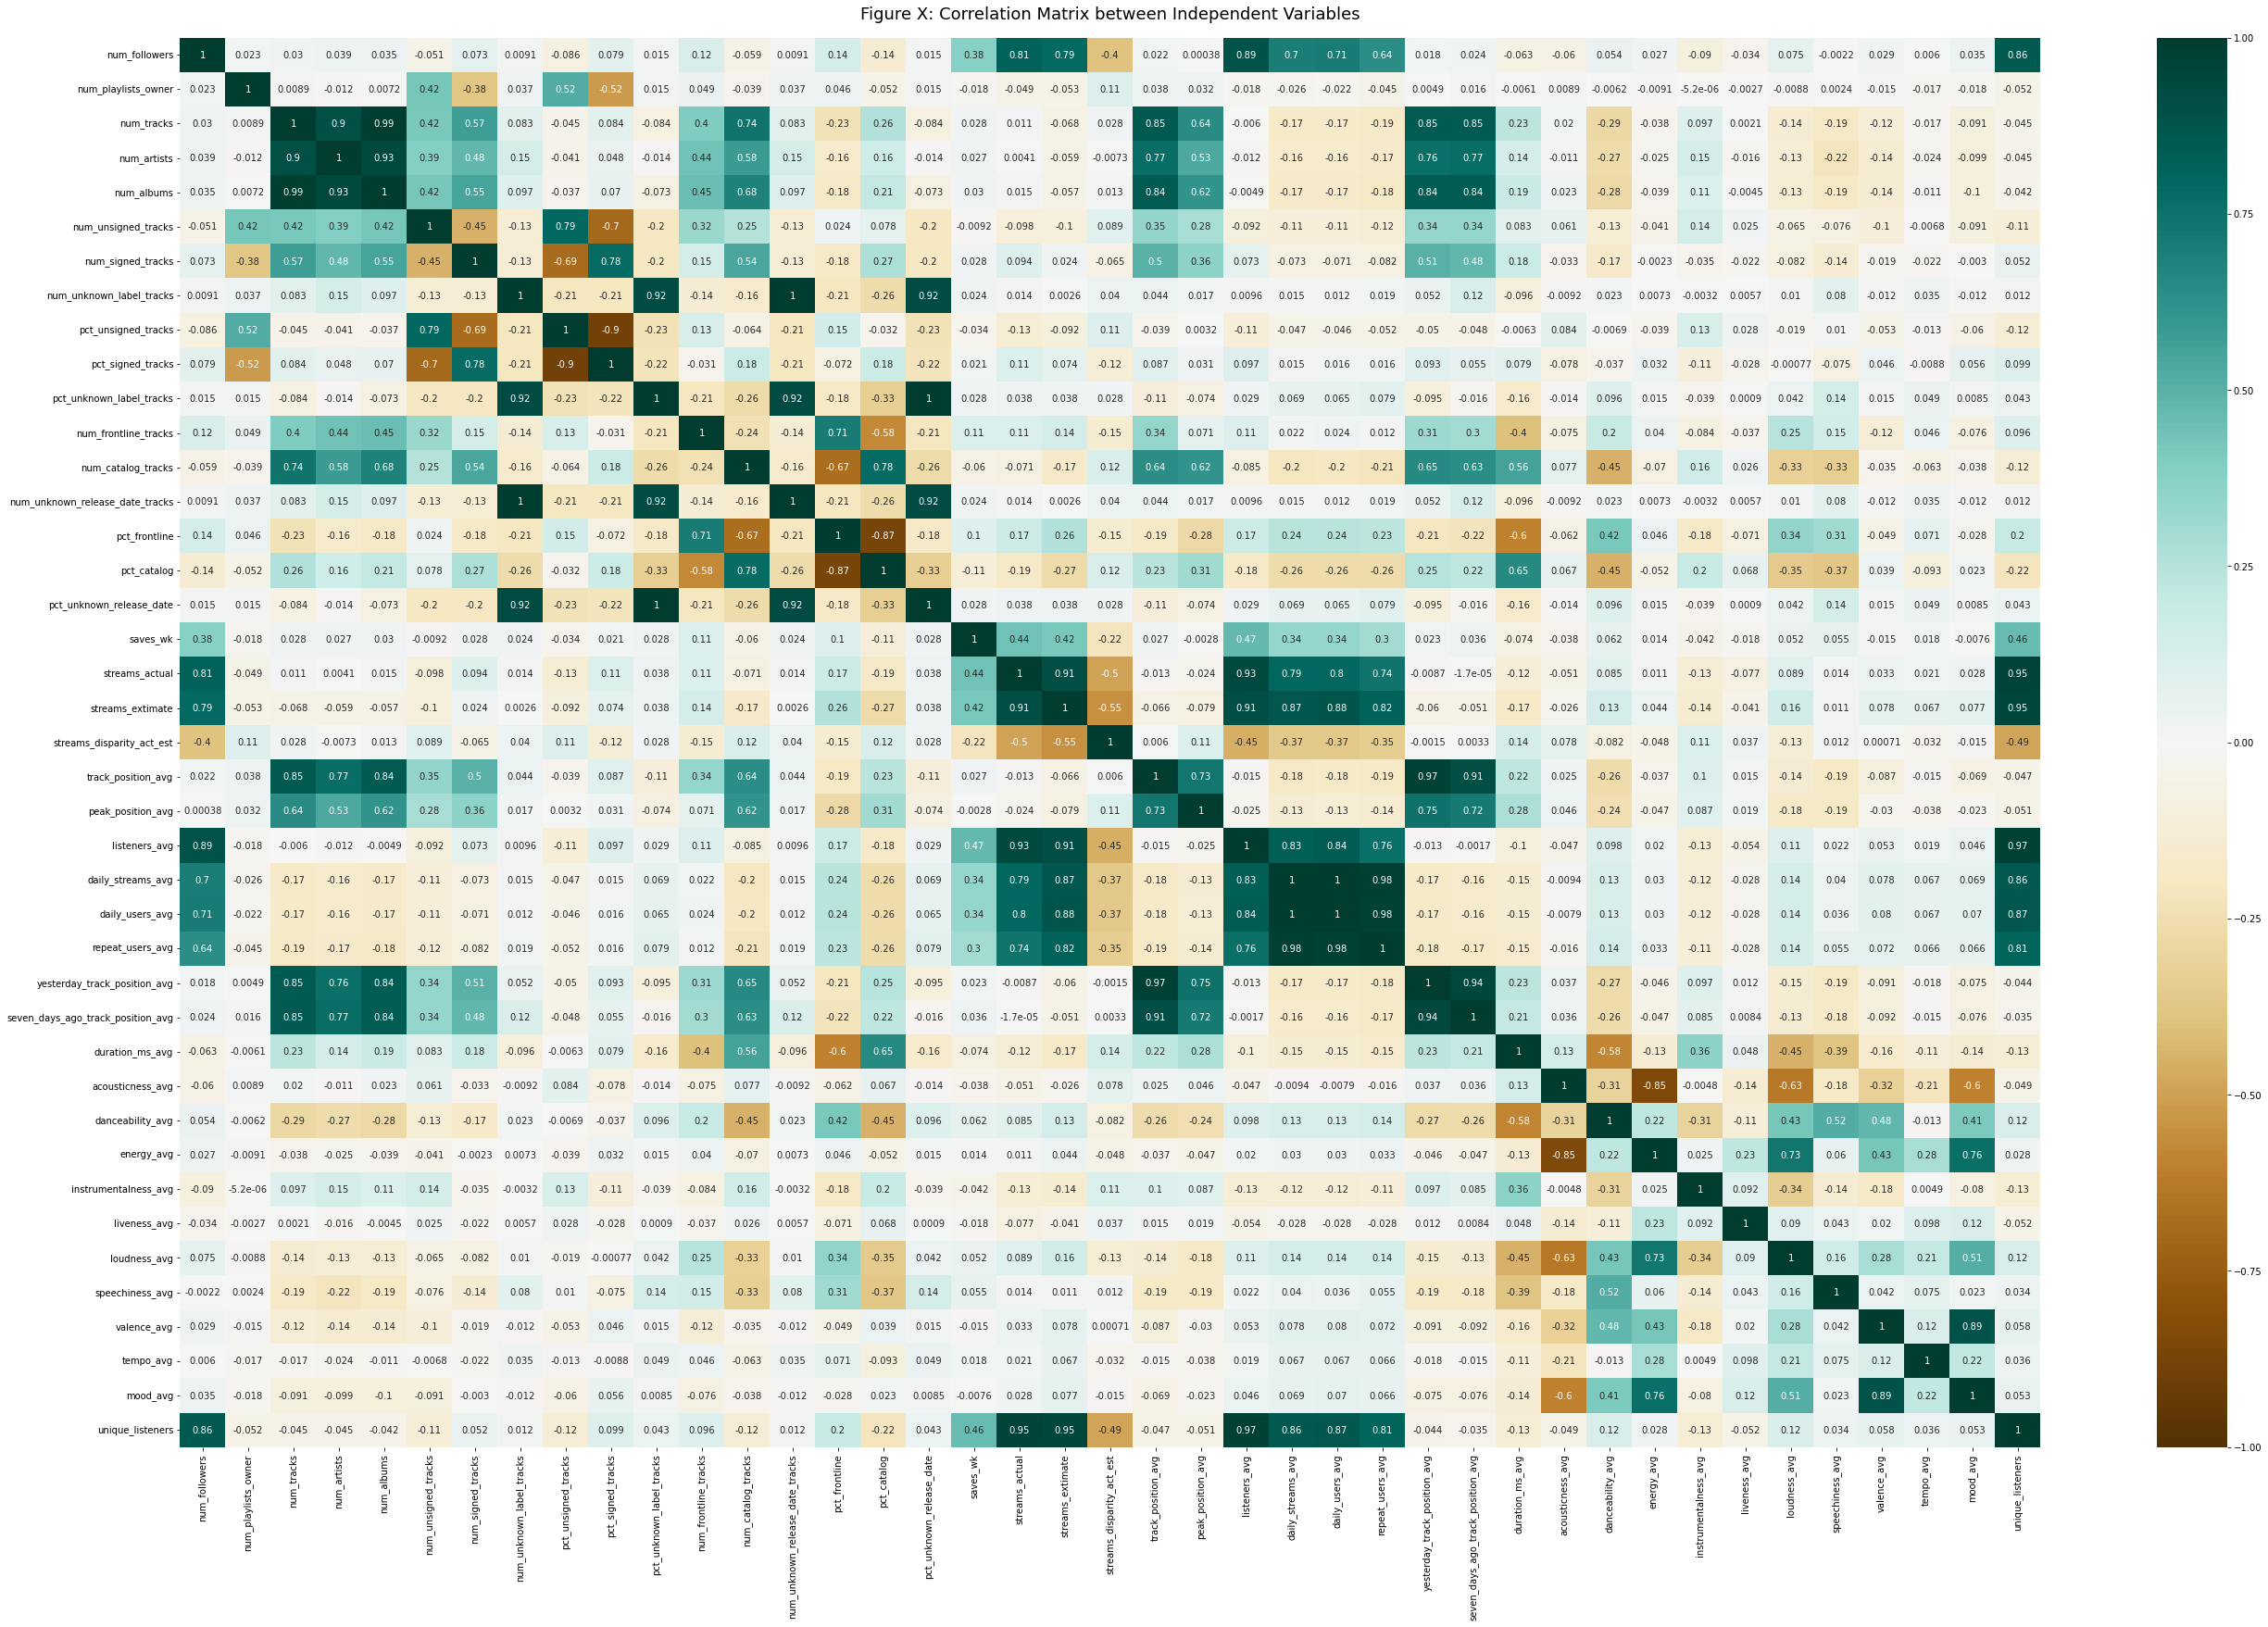

In [20]:
df.drop(['saves_cat'], axis = 1, inplace = True)
correlation_matrix = df.corr()
plt.figure(figsize=(45,28))
sns.heatmap(correlation_matrix, annot = True, vmin = -1, vmax = 1, cmap = 'BrBG')
plt.title("Figure X: Correlation Matrix between Independent Variables", fontsize = 18, pad = 20)
plt.show()

#### Feature Importance

In [30]:
df = pd.read_csv('df_done.csv')
df_idx = df.index
df.sort_values(['first_day','source_uri'],inplace = True)
df.set_index(['first_day'], inplace = True)

In [31]:
y = df[['saves_cat']]
X = df.drop(['saves_cat', 'source_uri', 'playlist_id', 'playlist_name','playlist_description','playlist_owner','image_url', 'top_genre','top_label', 'top_language', 'playlist_country_code', 'saves_wk'], axis = 1)

In [32]:
y_train, y_test, X_train, X_test = temporal_train_test_split(y, X=X)

<function matplotlib.pyplot.show(close=None, block=None)>

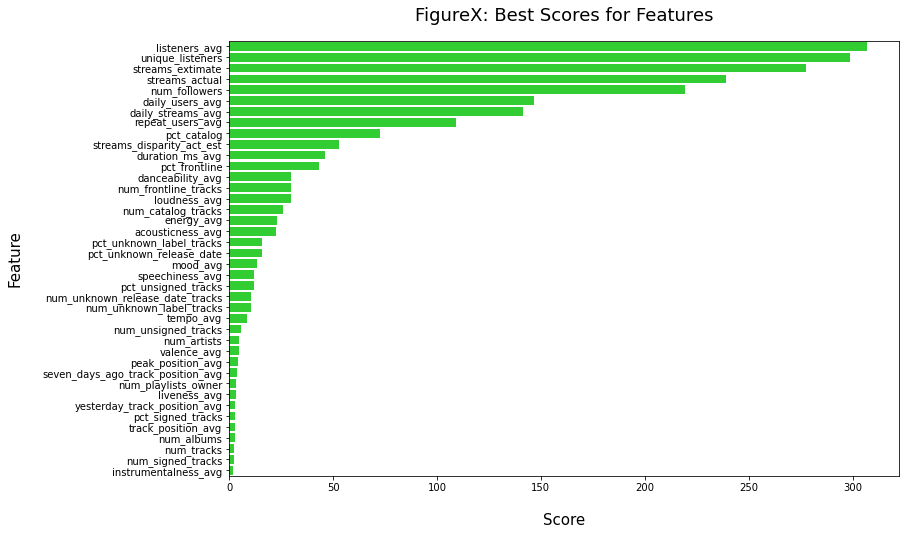

In [232]:
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import f_classif

Kbest = SelectKBest(score_func=f_classif, k='all')
Fit = Kbest.fit(X_train, y_train)

Kbest_scores = pd.DataFrame(Fit.scores_)
Kbest_columns = pd.DataFrame(X_train.columns)

Kbest_Dataframe = pd.concat([Kbest_scores,Kbest_columns], axis = 1)
Kbest_Dataframe.columns = ['Feature', 'Score']
fig, ax = plt.subplots(figsize = (12,8))
figX = sns.barplot(data=Kbest_Dataframe, x ='Feature', y='Score', color='limegreen', linewidth=0.5, saturation=2, orient='h',
order = Kbest_Dataframe.sort_values("Feature", ascending=False).Score)
plt.xlabel("Score", fontsize=15, labelpad=20)
plt.ylabel('Feature', fontsize=15, labelpad=20)
plt.title('FigureX: Best Scores for Features', fontsize=18, pad=20)
plt.show

#### Dropping appropriate features

In [250]:
df = pd.read_csv('df_done.csv')
df.drop(['saves_cat'], axis = 1, inplace = True)

In [251]:
df.columns

Index(['source_uri', 'first_day', 'playlist_id', 'playlist_name',
       'playlist_description', 'playlist_owner', 'image_url', 'num_followers',
       'num_playlists_owner', 'num_tracks', 'num_artists', 'num_albums',
       'num_unsigned_tracks', 'num_signed_tracks', 'num_unknown_label_tracks',
       'pct_unsigned_tracks', 'pct_signed_tracks', 'pct_unknown_label_tracks',
       'num_frontline_tracks', 'num_catalog_tracks',
       'num_unknown_release_date_tracks', 'pct_frontline', 'pct_catalog',
       'pct_unknown_release_date', 'playlist_country_code', 'saves_wk',
       'streams_actual', 'streams_extimate', 'streams_disparity_act_est',
       'track_position_avg', 'peak_position_avg', 'listeners_avg',
       'daily_streams_avg', 'daily_users_avg', 'repeat_users_avg',
       'yesterday_track_position_avg', 'seven_days_ago_track_position_avg',
       'duration_ms_avg', 'acousticness_avg', 'danceability_avg', 'energy_avg',
       'instrumentalness_avg', 'liveness_avg', 'loudness_avg'

In [262]:
# dropping features with a score of less than 25 after PCA
df.drop(['pct_unknown_label_tracks','pct_unknown_release_date','mood_avg','speechiness_avg','pct_unsigned_tracks',
            'num_unknown_release_date_tracks','num_unknown_label_tracks', 'tempo_avg','num_unsigned_tracks','num_artists',
            'valence_avg','peak_position_avg','seven_days_ago_track_position_avg','num_playlists_owner','liveness_avg',
            'yesterday_track_position_avg', 'pct_signed_tracks','track_position_avg','num_albums','num_tracks',
            'num_signed_tracks','instrumentalness_avg'], axis = 1, inplace = True)

In [263]:
# dropping multicollinear features over 0.8, if haven't been dropped already from PCA
df.drop(['listeners_avg', 'streams_actual', 'daily_users_avg', 'repeat_users_avg',  
              'pct_frontline','unique_listeners','saves_wk', 'daily_streams_avg','acousticness_avg'], axis = 1, inplace = True)

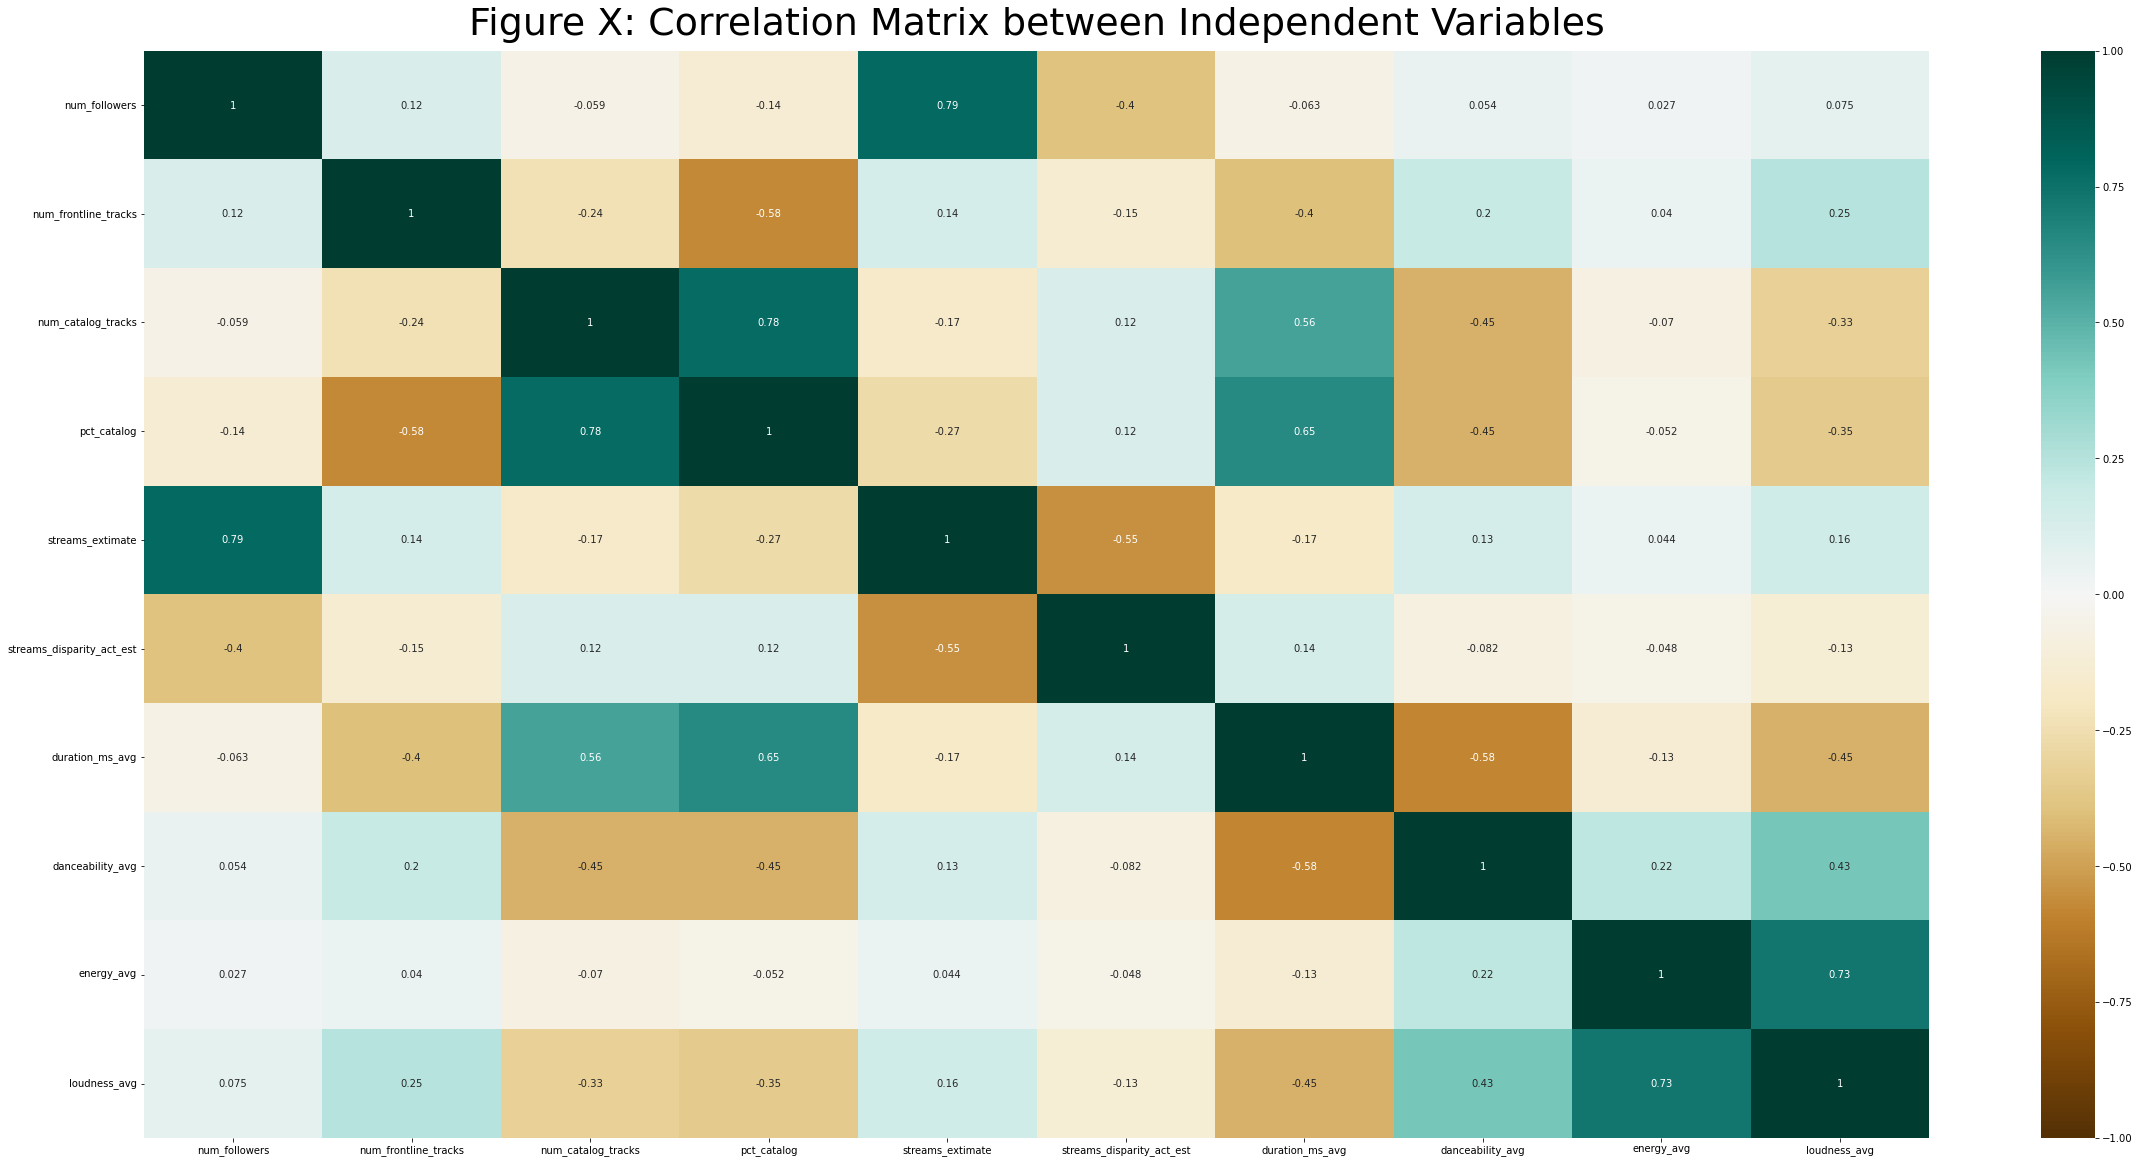

In [254]:
# checking new correlation matrix
correlation_matrix = df.corr()
plt.figure(figsize=(40,20))
sns.heatmap(correlation_matrix, annot = True, vmin = -1, vmax = 1, cmap = 'BrBG')
plt.title("Figure X: Correlation Matrix between Independent Variables", fontsize = 38, pad = 16)
plt.show()

#### Stationarity

In [7]:
df = pd.read_csv('df_done.csv')

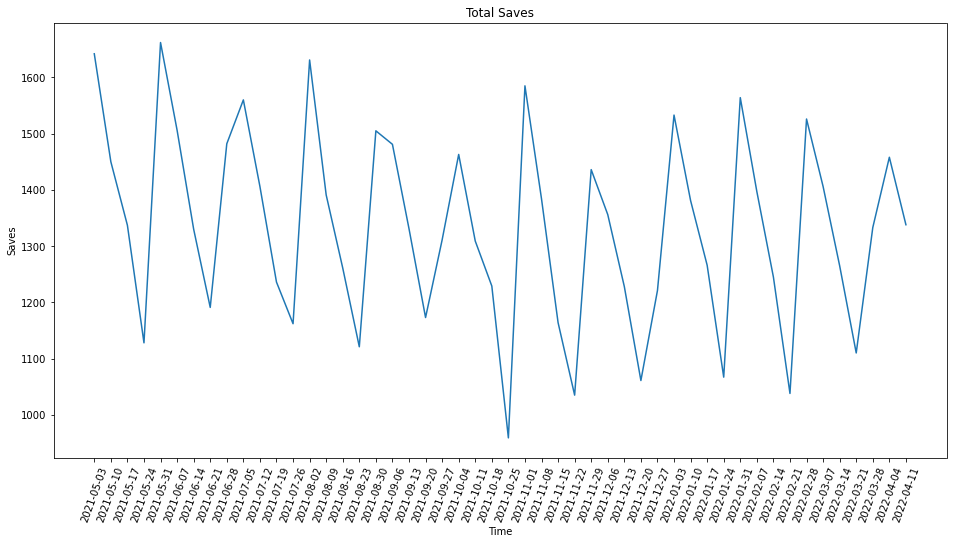

In [37]:
ts=df.groupby(["first_day"])["saves_cat"].sum()
ts.astype('float')
plt.figure(figsize=(16,8))
plt.title('Total Saves')
plt.xlabel('Time')
plt.ylabel('Saves')
plt.xticks(rotation=70)
plt.plot(ts);

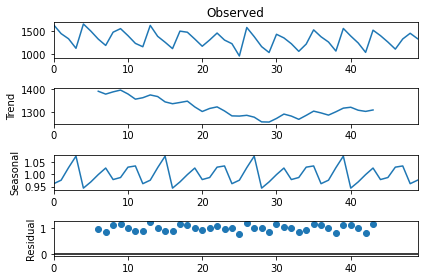

In [38]:
import statsmodels.api as sm
ts.index.freq = 'W-MON'
# multiplicative
res = sm.tsa.seasonal_decompose(ts.values,period=12,model="multiplicative")
#plt.figure(figsize=(16,12))
fig = res.plot()
#fig.show()

In [40]:
from statsmodels.tsa.stattools import adfuller, acf, pacf,arma_order_select_ic

In [41]:
# Stationarity tests
def test_stationarity(timeseries):
    
    #Perform Dickey-Fuller test:
    print('Results of Dickey-Fuller Test:')
    dftest = adfuller(timeseries, autolag='AIC')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)'%key] = value
    print (dfoutput)

test_stationarity(ts)

Results of Dickey-Fuller Test:
Test Statistic                 -2.364390
p-value                         0.152040
#Lags Used                     11.000000
Number of Observations Used    38.000000
Critical Value (1%)            -3.615509
Critical Value (5%)            -2.941262
Critical Value (10%)           -2.609200
dtype: float64


In [42]:
df['saves_diff'] = df['saves_cat'] - df['saves_cat'].shift(1)
df['saves_diff'].fillna(method='bfill',inplace = True)
df['adj_log'] = np.log(df['saves_cat'])
df['sqrt_log'] = np.sqrt(df['saves_cat'])
df['cbrt_log'] = np.cbrt(df['saves_cat'])

In [63]:
ts=df.groupby(["first_day"])["saves_cat"].diff(periods=1)
ts.astype('float')
ts.fillna(method='bfill', inplace=True)

In [64]:
test_stationarity(ts)

Results of Dickey-Fuller Test:
Test Statistic                   -24.961599
p-value                            0.000000
#Lags Used                        43.000000
Number of Observations Used    15006.000000
Critical Value (1%)               -3.430786
Critical Value (5%)               -2.861733
Critical Value (10%)              -2.566873
dtype: float64


In [ ]:
df['adj_log'] = np.log(df['saves_cat'])
df['sqrt_log'] = np.sqrt(df['saves_cat'])
df['cbrt_log'] = np.cbrt(df['saves_cat'])

## <u>Data Cleaning<u>

In [238]:
df = pd.read_csv('df_done.csv')

In [241]:
df.isna().sum() # - mood, and unique users

source_uri                              0
first_day                               0
playlist_id                             0
playlist_name                           0
playlist_description                    0
playlist_owner                          0
image_url                               0
num_followers                           0
num_playlists_owner                     0
num_tracks                              0
num_artists                             0
num_albums                              0
num_unsigned_tracks                     0
num_signed_tracks                       0
num_unknown_label_tracks                0
pct_unsigned_tracks                     0
pct_signed_tracks                       0
pct_unknown_label_tracks                0
num_frontline_tracks                    0
num_catalog_tracks                      0
num_unknown_release_date_tracks         0
pct_frontline                           0
pct_catalog                             0
pct_unknown_release_date          

#### Imputing for null values

In [242]:
df['playlist_country_code'] = df['playlist_country_code'].fillna('Unknown')
df['top_label'] = df['top_label'].fillna('Unknown')

In [244]:
df.set_index(['source_uri','first_day'],inplace = True)
df.fillna(df.mean(level=0),inplace = True)
df.reset_index(inplace =True)
# saving to csv
df.to_csv('df_done.csv', index = False)

## <u>Pre-Processing<u>

In [29]:
df = pd.read_csv('df_done.csv')

In [30]:
# Dropping features with a score of less than 25 after feature importance
df.drop(['pct_unknown_label_tracks','pct_unknown_release_date','mood_avg','speechiness_avg','pct_unsigned_tracks',
            'num_unknown_release_date_tracks','num_unknown_label_tracks', 'tempo_avg','num_unsigned_tracks','num_artists',
            'valence_avg','peak_position_avg','seven_days_ago_track_position_avg','num_playlists_owner','liveness_avg',
            'yesterday_track_position_avg', 'pct_signed_tracks','track_position_avg','num_albums','num_tracks',
            'num_signed_tracks','instrumentalness_avg'], axis = 1, inplace = True)

In [31]:
# Dropping multicollinear features over 0.8, if haven't been dropped already from PCA
df.drop(['listeners_avg', 'streams_actual', 'daily_users_avg', 'repeat_users_avg',  
              'pct_frontline','unique_listeners','saves_wk', 'daily_streams_avg','acousticness_avg'], axis = 1, inplace = True)

In [32]:
# Creating features to induce stationarity
df['saves_diff'] = df['saves_cat'] - df['saves_cat'].shift(1)
df['saves_diff'].fillna(method='bfill',inplace = True)
df['adj_log'] = np.log(df['saves_cat'])
df['sqrt_log'] = np.sqrt(df['saves_cat'])
df['cbrt_log'] = np.cbrt(df['saves_cat'])

In [33]:
# dropping inappropriate features
df.drop(['playlist_id', 'playlist_description', 'playlist_owner', 'image_url'], axis = 1, inplace = True)

#### Label encoding

In [34]:
# defining the encoder
label_encoder = preprocessing.LabelEncoder()

In [35]:
# encoding categorical features
df['playlist_name'] = label_encoder.fit_transform(df['playlist_name']) 
df['playlist_country_code'] = label_encoder.fit_transform(df['playlist_country_code']) 
df['top_genre'] = label_encoder.fit_transform(df['top_genre']) 
df['top_label'] = label_encoder.fit_transform(df['top_label']) 
df['top_language'] = label_encoder.fit_transform(df['top_language']) 

In [36]:
# setting date to datetime
df['first_day'] = df['first_day'].astype('datetime64')
#creating an array of y values
y = np.array(df['saves_cat'])
y = y.astype('<U9')
# dropping the dependent variable from the feature set
df.drop(['saves_cat'], axis = 1, inplace = True)
df['first_day'].nunique()
df.set_index(['source_uri','first_day'], inplace = True)

#### Scaling the data

In [37]:
# defining the scaler
scaler = MinMaxScaler()

In [38]:
# fitting and transforming the scaler onto the dataframe's columns
df[df.columns] = scaler.fit_transform(df[df.columns])

#### Creating 3-d numpy array

In [39]:
n_max = df.groupby(['source_uri','first_day']).size().max()
a3e = np.array(list(df.groupby(['source_uri','first_day']).apply(pd.DataFrame.to_numpy)
                    .apply(lambda x: np.pad(x, ((0, n_max-len(x)), (0, 0)), 'constant'))))

In [40]:
a3e.shape

(15050, 1, 19)

#### Converting 3-d numpy array to a nested dataframe

In [41]:
df_n = from_3d_numpy_to_nested(a3e, cells_as_numpy = False)

In [42]:
X_train, X_test, y_train, y_test = temporal_train_test_split(df_n, y)

#### Time-series transformation (using ROCKET)

In [43]:
rocket = Rocket()
rocket.fit(X_train)
X_train_transform = rocket.transform(X_train)

In [44]:
X_test_transform = rocket.transform(X_test)

#### Fitting the models

##### Cross-validation accuracy

In [45]:
from sklearn.model_selection import cross_val_score 

In [46]:
def display_scores(scores):
    print("Scores:", scores)
    print("Mean:", scores.mean()) 
    print("Standard deviation:", scores.std())

# <b>Modelling<b>

## <u>Model Fit and Accuracy<u>

#### Ridge Classifier

In [47]:
## ACC = 74%
rid_classifier = RidgeClassifier()
rid_classifier.fit(X_train_transform, y_train)
y_pred = rid_classifier.predict(X_test_transform)

In [48]:
#Cross-validation
scores = cross_val_score(rid_classifier, X_test_transform, y_test, scoring="accuracy", cv=6) 
display_scores(scores)

Scores: [0.68471338 0.82137161 0.81977671 0.77990431 0.6092504  0.71610845]
Mean: 0.7385208098416278
Standard deviation: 0.07668959505041156


#### Stochastic Gradient Descent

In [ ]:
from sklearn.linear_model import SGDClassifier
## ACC = 70%

sgd_classifier = SGDClassifier()
sgd_classifier.fit(X_train_transform, y_train)
y_pred = sgd_classifier.predict(X_test_transform)

In [ ]:
#Cross-validation
scores = cross_val_score(sgd_classifier, X_test_transform, y_test, scoring="accuracy", cv=6) 

In [44]:
display_scores(scores)

Scores: [0.7022293  0.71610845 0.72727273 0.68580542 0.6953748  0.67623604]
Mean: 0.7005044579214877
Standard deviation: 0.017293211033664563


#### Dummy Classifier

In [45]:
from sklearn.dummy import DummyClassifier
## ACC = 32%

dum_classifier = DummyClassifier()
dum_classifier.fit(X_train_transform, y_train)
y_pred = dum_classifier.predict(X_test_transform)

In [46]:
#Cross-validation
scores = cross_val_score(dum_classifier, X_test_transform, y_test, scoring="accuracy", cv=6) 
display_scores(scores)

Scores: [0.32006369 0.32216906 0.32216906 0.32216906 0.32057416 0.32057416]
Mean: 0.32128653277664343
Standard deviation: 0.0008987800986223317


#### Logistic Regression

In [21]:
from sklearn.linear_model import LogisticRegression

In [49]:
## ACC = 75%

log_classifier = LogisticRegression()
log_classifier.fit(X_train_transform, y_train)
y_pred = log_classifier.predict(X_test_transform)

In [50]:
#Cross-validation
scores = cross_val_score(log_classifier, X_test_transform, y_test, scoring="accuracy", cv=6) 
display_scores(scores)

Scores: [0.69426752 0.82934609 0.7400319  0.75917065 0.71451356 0.76714514]
Mean: 0.7507458087411155
Standard deviation: 0.04307992974765244


#### Passive Aggresive Classifier

In [51]:
from sklearn.linear_model import PassiveAggressiveClassifier
## ACC = 70%

pa_classifier = PassiveAggressiveClassifier()
pa_classifier.fit(X_train_transform, y_train)
y_pred = pa_classifier.predict(X_test_transform)

In [52]:
#Cross-validation
scores = cross_val_score(pa_classifier, X_test_transform, y_test, scoring="accuracy", cv=6) 
display_scores(scores)

Scores: [0.71656051 0.72567783 0.74162679 0.71610845 0.64752791 0.65709729]
Mean: 0.700766464511017
Standard deviation: 0.035393765279738164


#### Perceptron

In [53]:
from sklearn.linear_model import Perceptron
## ACC = 66%

prc_classifier = Perceptron()
prc_classifier.fit(X_train_transform, y_train)
y_pred = prc_classifier.predict(X_test_transform)

In [54]:
#Cross-validation
scores = cross_val_score(prc_classifier, X_test_transform, y_test, scoring="accuracy", cv=6) 
display_scores(scores)

Scores: [0.55732484 0.74960128 0.58213716 0.71451356 0.71610845 0.62838915]
Mean: 0.658012407006708
Standard deviation: 0.07271935481307212


#### Multi-layer Perceptron (Neural Network)

In [22]:
from sklearn.neural_network import MLPClassifier

In [55]:
## ACC = 73%
mlp_classifier = MLPClassifier()
mlp_classifier.fit(X_train_transform, y_train)
y_pred = mlp_classifier.predict(X_test_transform)

In [56]:
#Cross-validation
scores = cross_val_score(mlp_classifier, X_test_transform, y_test, scoring="accuracy", cv=6) 
display_scores(scores)

Scores: [0.80573248 0.89314195 0.79425837 0.84529506 0.6969697  0.32057416]
Mean: 0.7259952864210324
Standard deviation: 0.19078656610546504


#### Random Forest Classifier

In [23]:
from sklearn.ensemble import RandomForestClassifier

In [22]:
## ACC = 84%

rf_classifier = RandomForestClassifier()
rf_classifier.fit(X_train_transform, y_train)
y_pred = rf_classifier.predict(X_test_transform)

In [58]:
#Cross-validation
scores = cross_val_score(rf_classifier, X_test_transform, y_test, scoring="accuracy", cv=6) 
display_scores(scores)

Scores: [0.75159236 0.89154705 0.89314195 0.83732057 0.77511962 0.87878788]
Mean: 0.837918237013108
Standard deviation: 0.05626161600457186


## <u>Hyperparamter tuning<u>

In [ ]:
# tuning hyperparameters of top 3/4 classifier accuracy scores (Random Forest, Ridge clf, Logistic Regression & MLP?)

##### Random Forest clf Hyperparameter tuning

In [29]:
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.model_selection import GridSearchCV

In [74]:
model = RandomForestClassifier()
n_estimators = [10, 100, 1000]
max_features = ['sqrt', 'log2']
# define grid search
grid = dict(n_estimators=n_estimators,max_features=max_features)
cv = RepeatedStratifiedKFold(n_splits=4, n_repeats= 2, random_state=1)
grid_search = GridSearchCV(estimator=model, param_grid=grid, n_jobs=-1, cv=cv, scoring='accuracy',error_score=0)
grid_result = grid_search.fit(X_train_transform, y_train)
# summarize results
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (mean, stdev, param))

Best: 0.962524 using {'max_features': 'sqrt', 'n_estimators': 1000}
0.932489 (0.003168) with: {'max_features': 'sqrt', 'n_estimators': 10}
0.957163 (0.003194) with: {'max_features': 'sqrt', 'n_estimators': 100}
0.962524 (0.003105) with: {'max_features': 'sqrt', 'n_estimators': 1000}
0.902543 (0.006527) with: {'max_features': 'log2', 'n_estimators': 10}
0.939089 (0.003711) with: {'max_features': 'log2', 'n_estimators': 100}
0.943165 (0.003134) with: {'max_features': 'log2', 'n_estimators': 1000}


In [26]:
## ACC = 85%
rf_post_tune_classifier = RandomForestClassifier(max_features = 'sqrt', n_estimators = 1000)
rf_post_tune_classifier.fit(X_train_transform, y_train)
y_pred = rf_post_tune_classifier.predict(X_test_transform)

In [56]:
#Cross-validation
scores = cross_val_score(rf_post_tune_classifier, X_test_transform, y_test, scoring="accuracy", cv=6) 
display_scores(scores)

Scores: [0.7611465  0.8708134  0.89473684 0.87719298 0.75438596 0.91547049]
Mean: 0.8456243629726701
Standard deviation: 0.06374759866506041


##### Ridge clf Hyperparameter tuning

In [29]:
model = RidgeClassifier()
alpha = [0.1, 0.5, 0.9]
# define grid search
grid = dict(alpha=alpha)
cv = RepeatedStratifiedKFold(n_splits=4, n_repeats=2, random_state=1)
grid_search = GridSearchCV(estimator=model, param_grid=grid, n_jobs=None, cv=cv, scoring='accuracy',error_score=0)
grid_result = grid_search.fit(X_train_transform, y_train)
# summarize results
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (mean, stdev, param))

Best: 0.937096 using {'alpha': 0.5}
0.936609 (0.003566) with: {'alpha': 0.1}
0.937096 (0.004385) with: {'alpha': 0.5}
0.936874 (0.004451) with: {'alpha': 0.9}


In [36]:
rid_post_tune_classifier = RidgeClassifier(alpha = 0.5)
rid_post_tune_classifier.fit(X_train_transform, y_train)
y_pred = rid_post_tune_classifier.predict(X_test_transform)

In [52]:
#Cross-validation
scores = cross_val_score(rid_post_tune_classifier, X_test_transform, y_test, scoring="accuracy", cv=6) 
display_scores(scores)

Scores: [0.63853503 0.84848485 0.80701754 0.79904306 0.6937799  0.64114833]
Mean: 0.7380014526762766
Standard deviation: 0.08359178804260559


##### Logistic Regression Hyperparameter tuning

In [28]:
model = LogisticRegression()
c_values = [10, 1.0, 0.1]
# define grid search
grid = dict(C=c_values)
cv = RepeatedStratifiedKFold(n_splits=2, n_repeats=2, random_state=1)
grid_search = GridSearchCV(estimator=model, param_grid=grid, n_jobs=None, cv=cv, scoring='accuracy',error_score=0)
grid_result = grid_search.fit(X_train_transform, y_train)
# summarize results
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (mean, stdev, param))

Best: 0.887083 using {'C': 10}
0.887083 (0.001908) with: {'C': 10}
0.883716 (0.001103) with: {'C': 1.0}
0.881013 (0.005311) with: {'C': 0.1}


In [27]:
log_post_tune_classifier = LogisticRegression(C=10)
log_post_tune_classifier.fit(X_train_transform, y_train)
y_pred = log_post_tune_classifier.predict(X_test_transform)

In [36]:
#Cross-validation
scores = cross_val_score(log_post_tune_classifier, X_test_transform, y_test, scoring="accuracy", cv=6) 
display_scores(scores)

Scores: [0.70541401 0.84210526 0.74322169 0.80063796 0.72567783 0.76555024]
Mean: 0.7637678325324989
Standard deviation: 0.04614740270115864


##### Multi-layer Perceptron Hyperparameter tuning

In [31]:
model = MLPClassifier(max_iter=100)
parameter_space = {
    'hidden_layer_sizes': [(50,50,50), (50,100,50)],
    'activation': ['tanh', 'relu'],
    'solver': ['sgd', 'adam'],
    'alpha': [0.0001, 0.05]
}
clf = GridSearchCV(model, parameter_space, n_jobs=None, cv=2)
clf.fit(X_train_transform, y_train)
# Best paramete set
print('Best parameters found:\n', clf.best_params_)

# All results
means = clf.cv_results_['mean_test_score']
stds = clf.cv_results_['std_test_score']
for mean, std, params in zip(means, stds, clf.cv_results_['params']):
    print("%0.3f (+/-%0.03f) for %r" % (mean, std * 2, params))

Best parameters found:
 {'activation': 'relu', 'alpha': 0.05, 'hidden_layer_sizes': (50, 100, 50), 'solver': 'adam'}
0.414 (+/-0.291) for {'activation': 'tanh', 'alpha': 0.0001, 'hidden_layer_sizes': (50, 50, 50), 'solver': 'sgd'}
0.269 (+/-0.000) for {'activation': 'tanh', 'alpha': 0.0001, 'hidden_layer_sizes': (50, 50, 50), 'solver': 'adam'}
0.443 (+/-0.000) for {'activation': 'tanh', 'alpha': 0.0001, 'hidden_layer_sizes': (50, 100, 50), 'solver': 'sgd'}
0.269 (+/-0.000) for {'activation': 'tanh', 'alpha': 0.0001, 'hidden_layer_sizes': (50, 100, 50), 'solver': 'adam'}
0.451 (+/-0.364) for {'activation': 'tanh', 'alpha': 0.05, 'hidden_layer_sizes': (50, 50, 50), 'solver': 'sgd'}
0.269 (+/-0.000) for {'activation': 'tanh', 'alpha': 0.05, 'hidden_layer_sizes': (50, 50, 50), 'solver': 'adam'}
0.443 (+/-0.010) for {'activation': 'tanh', 'alpha': 0.05, 'hidden_layer_sizes': (50, 100, 50), 'solver': 'sgd'}
0.269 (+/-0.000) for {'activation': 'tanh', 'alpha': 0.05, 'hidden_layer_sizes': (50,

In [28]:
mlp_post_tune_classifier = MLPClassifier(activation = 'relu', alpha = 0.05, hidden_layer_sizes = (50,100,50), solver = 'adam', max_iter=100)
mlp_post_tune_classifier.fit(X_train_transform, y_train)
y_pred = mlp_post_tune_classifier.predict(X_test_transform)

In [34]:
#Cross-validation
scores = cross_val_score(mlp_post_tune_classifier, X_test_transform, y_test, scoring="accuracy", cv=6) 
display_scores(scores)

Scores: [0.85987261 0.96969697 0.9569378  0.93301435 0.88357257 0.87240829]
Mean: 0.9125837659193342
Standard deviation: 0.04258480018467864


## <u>Ensemble method - Stacking classifier<u>

In [ ]:
## Stacking classifier - use both silver work (change from reg to class), and machine learning mastery

In [30]:
from sklearn.ensemble import StackingClassifier

In [35]:
from sklearn.model_selection import TimeSeriesSplit

In [34]:
# ridge classifier didn't improve so use original, but tunes rf, mlp, log reg

In [32]:
cv = 3
# define the base models
level0 = list()
level0.append(('Random Forest p-t clf', rf_post_tune_classifier))
level0.append(('Ridge clf', rid_classifier))
level0.append(('Logistic p-t reg', log_post_tune_classifier))
level0.append(('MLP p-t (Neural Network)', mlp_post_tune_classifier))
level1 = LogisticRegression()
# define the stacking ensemble
stacking_model = StackingClassifier(estimators=level0, final_estimator=level1, 
                                    cv=TimeSeriesSplit(n_splits=cv).get_n_splits([X_train_transform, y_train]), n_jobs = None)

stacking_model.fit(X_train_transform, y_train)

StackingClassifier(cv=3,
                   estimators=[('Random Forest p-t clf',
                                RandomForestClassifier(max_features='sqrt',
                                                       n_estimators=1000)),
                               ('Ridge clf', RidgeClassifier()),
                               ('Logistic p-t reg', LogisticRegression(C=10)),
                               ('MLP p-t (Neural Network)',
                                MLPClassifier(alpha=0.05,
                                              hidden_layer_sizes=(50, 100, 50),
                                              max_iter=100))],
                   final_estimator=LogisticRegression())

In [33]:
#Cross-validation
scores = cross_val_score(stacking_model, X_test_transform, y_test, scoring="accuracy", cv=4)

In [ ]:
display_scores(scores)

Scores: [0.94580234 0.93623804 0.91604676 0.88510638]
Mean: 0.9207983810794311
Standard deviation: 0.023238318098996028


## <u>Model selection<u> 

In [49]:
model_evaluation = {}
model_evaluation['Bnmrk Dummy clf'] = 0.32
model_evaluation['Ridge clf'] = 0.74 
model_evaluation['SGD clf'] = 0.7
model_evaluation['Logistic reg'] = 0.75
model_evaluation['Pass Agg clf'] = 0.7
model_evaluation['Perceptron'] = 0.66
model_evaluation['MLP clf'] = 0.73
model_evaluation['Random Forest clf'] = 0.84
model_evaluation['Random Forest clf post-tune'] = 0.85
model_evaluation['Ridge clf post-tune'] = 0.74
model_evaluation['Logistic reg post-tune'] = 0.76
model_evaluation['MLP reg post-tune'] = 0.91
model_evaluation['Ensemble Stacking clf'] = 0.92

In [50]:
## EDIT
x = ['Ensemble Stacking clf','MLP reg post-tune', 'Random Forest clf post-tune', 'Random Forest clf', 'Logistic reg post-tune', 'Logistic reg', 
    'Ridge clf post-tune', 'Ridge clf', 'MLP clf', 'SGD clf', 'Pass Agg clf', 'Perceptron', 'Bnmrk Dummy clf']
h = [model_evaluation['Ensemble Stacking clf'],
     model_evaluation['MLP reg post-tune'],
     model_evaluation['Random Forest clf post-tune'],
     model_evaluation['Random Forest clf'],
     model_evaluation['Logistic reg post-tune'],
     model_evaluation['Logistic reg'],
     model_evaluation['Ridge clf post-tune'],
     model_evaluation['Ridge clf'],
     model_evaluation['MLP clf'],
     model_evaluation['SGD clf'],
     model_evaluation['Pass Agg clf'],
     model_evaluation['Perceptron'],
     model_evaluation['Bnmrk Dummy clf']
    ]
c = ['green', 'orange', 'orange', 'orange', 'orange', 'orange','orange', 'orange', 'red', 'red', 'red' , 'red' , 'red']

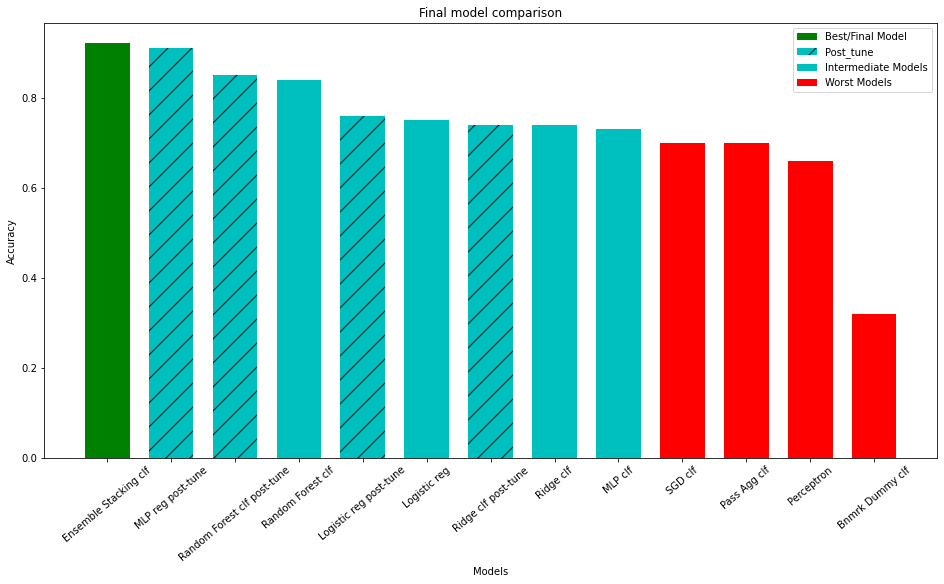

In [51]:
plt.figure(figsize=(16,8))
plt.bar(x[0],h[0],label='Best/Final Model',color='g', width = 0.7)
plt.bar(x[1],h[1],label='Post_tune', color='c', width = 0.7, hatch = '/')
plt.bar(x[2],h[2],color='c', width = 0.7, hatch = '/')
plt.bar(x[3],h[3],label='Intermediate Models',color='c', width = 0.7)
plt.bar(x[4],h[4],color='c', width = 0.7, hatch = '/')
plt.bar(x[5],h[5],color='c', width = 0.7)
plt.bar(x[6],h[6],color='c', width = 0.7, hatch = '/')
plt.bar(x[7],h[7],color='c', width = 0.7)
plt.bar(x[8],h[8],color='c', width = 0.7)
plt.bar(x[9],h[9],label='Worst Models', color='r', width = 0.7)
plt.bar(x[10],h[10],color='r', width = 0.7)
plt.bar(x[11],h[11],color='r', width = 0.7)
plt.bar(x[12],h[12],color='r', width = 0.7)
plt.xlabel('Models')
plt.ylabel('Accuracy')
plt.title('Final model comparison')
plt.xticks(rotation=40)
plt.legend()
plt.show()

## <u>Model Evaluation<u>

In [46]:
y_pred = stacking_model.predict(X_test_transform)

In [47]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

In [48]:
cm = confusion_matrix(y_test, y_pred, labels = stacking_model.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                               display_labels=stacking_model.classes_)

In [40]:
from sklearn import metrics

In [66]:
from sklearn.metrics import classification_report

In [68]:
print(classification_report(y_test, y_pred, target_names=stacking_model.classes_))

              precision    recall  f1-score   support

           1       0.99      1.00      1.00      1209
          10       0.80      0.59      0.68        56
          11       0.97      0.99      0.98       764
           2       1.00      0.98      0.99       634
           3       0.99      1.00      1.00       370
           4       1.00      1.00      1.00       231
           5       0.99      1.00      1.00       161
           6       0.99      0.96      0.97       121
           7       0.88      0.96      0.92        79
           8       0.73      0.88      0.80        65
           9       0.86      0.70      0.77        73

    accuracy                           0.98      3763
   macro avg       0.93      0.91      0.92      3763
weighted avg       0.98      0.98      0.98      3763



In [69]:
from sklearn.metrics import roc_auc_score

In [77]:
y_prob = stacking_model.predict_proba(X_test_transform)

In [79]:
roc_auc_score(y_test, y_prob, multi_class = 'ovr', average = 'weighted')

0.9997460325482102

In [82]:
##plot_roc_curve

In [81]:
pip install yellowbrick

  Using cached yellowbrick-1.4-py3-none-any.whl (274 kB)
Note: you may need to restart the kernel to use updated packages.


In [82]:
from yellowbrick.classifier import ClassificationReport

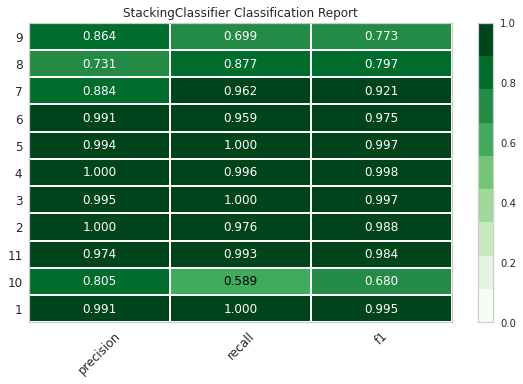

<AxesSubplot:title={'center':'StackingClassifier Classification Report'}>

In [96]:
visualizer = ClassificationReport(stacking_model, classes=stacking_model.classes_, support= False, cmap = 'greens')

visualizer.fit(X_train_transform, y_train)        # Fit the visualizer and the model
visualizer.score(X_test_transform, y_test)        # Evaluate the model on the test data
visualizer.show() 

#### EDA as to which playlists should be focused on for forcasting

In [ ]:
# This was done for each genre
df = pd.read_csv('df_done.csv')
df.set_index(['source_uri'], inplace = True)

In [ ]:
df['diff_saves'] = df.groupby(['source_uri'])['saves_wk'].max()-df['saves_wk'].min()

In [ ]:
df_rock = df.loc[df['top_genre'] == 'Rock']
df_rock = df_rock[~df_rock.index.duplicated(keep='first')]
df_rock.nlargest(58, 'diff_saves')

# <b>Forecasting<b>

In [12]:
df = pd.read_csv('df_done.csv')

In [13]:
df['saves_diff'] = df['saves_cat'] - df['saves_cat'].shift(1)
df['saves_diff'].fillna(method='bfill',inplace = True)
df['adj_log'] = np.log(df['saves_cat'])
df['sqrt_log'] = np.sqrt(df['saves_cat'])
df['cbrt_log'] = np.cbrt(df['saves_cat'])

### For each playlist identified, the playlist name is imputed below

In [14]:
# Locating specific playlist from multiindex
# sad hour is the given example here
df = df.loc[df['playlist_name'] == 'sad hour']
df = df[['saves_wk','energy_avg']]

In [15]:
idx = pd.period_range(start='2021-05-03', end='2022-04-11', freq='W')
df.set_index(idx,inplace = True)

In [16]:
df.drop(['energy_avg'], inplace = True, axis = 1)

In [25]:
len(df)

50

In [18]:
train = df
scaler = MinMaxScaler()
scaler.fit(train)
train = scaler.transform(train)

In [19]:
# Defining number of inputs, features and generator
n_input = 49
n_features = 1
generator = TimeseriesGenerator(train, train, length=n_input, batch_size=11)

In [20]:
# Compiling and fitting the model
model = Sequential()
model.add(LSTM(200, activation='relu', input_shape=(n_input, n_features)))
model.add(Dropout(0.15))
model.add(Dense(1))
optimizer = keras.optimizers.Adam(learning_rate=0.001)
model.compile(optimizer=optimizer, loss='mse')
history = model.fit_generator(generator,epochs=100,verbose=1)

2022-07-24 16:24:42.829000: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /usr/local/cuda/lib64:/usr/local/cuda/lib:/usr/local/lib/x86_64-linux-gnu:/usr/local/nvidia/lib:/usr/local/nvidia/lib64:/usr/local/nvidia/lib:/usr/local/nvidia/lib64
2022-07-24 16:24:42.829053: W tensorflow/stream_executor/cuda/cuda_driver.cc:269] failed call to cuInit: UNKNOWN ERROR (303)
2022-07-24 16:24:42.829127: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (024654d3561d): /proc/driver/nvidia/version does not exist
2022-07-24 16:24:42.845659: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in 

Epoch 1/100
1/1 [==============================] - 1s 1s/step - loss: 0.1446
Epoch 2/100
1/1 [==============================] - 0s 49ms/step - loss: 0.1147
Epoch 3/100
1/1 [==============================] - 0s 44ms/step - loss: 0.1020
Epoch 4/100
1/1 [==============================] - 0s 43ms/step - loss: 0.0872
Epoch 5/100
1/1 [==============================] - 0s 41ms/step - loss: 0.0703
Epoch 6/100
1/1 [==============================] - 0s 45ms/step - loss: 0.0544
Epoch 7/100
1/1 [==============================] - 0s 49ms/step - loss: 0.0405
Epoch 8/100
1/1 [==============================] - 0s 43ms/step - loss: 0.0204
Epoch 9/100
1/1 [==============================] - 0s 42ms/step - loss: 0.0127
Epoch 10/100
1/1 [==============================] - 0s 41ms/step - loss: 0.0037
Epoch 11/100
1/1 [==============================] - 0s 41ms/step - loss: 0.0152
Epoch 12/100
1/1 [==============================] - 0s 43ms/step - loss: 0.0202
Epoch 13/100
1/1 [==============================] -

In [21]:
pred_list = []
batch = train[-n_input:].reshape((1, n_input, n_features))
for i in range(n_input):   
    pred_list.append(model.predict(batch)[0]) 
    batch = np.append(batch[:,1:,:],[[pred_list[i]]],axis=1)

1/1 [==============================] - 0s 24ms/step


In [22]:
add_dates = [df.index[-1] + x for x in range(0,50) ]
future_dates = pd.DataFrame(index=add_dates[1:],columns=df.columns)

In [23]:
df_predict = pd.DataFrame(scaler.inverse_transform(pred_list),
                          index=future_dates[-n_input:].index, columns=['Prediction'])
df_proj = pd.concat([df,df_predict], axis=1)
df_proj = df_proj.head(90)

<AxesSubplot:>

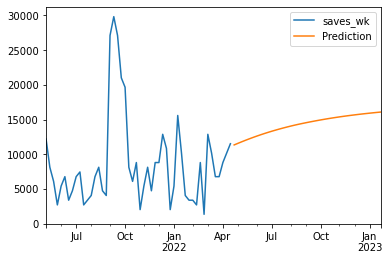

In [24]:
# Forecasting example for 'sad hour' (specified in a cell above)
df_proj.plot()